In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [404]:
def sep():
    print("\n" + "-"*50 + "\n")

def pretty(x):
    print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in x]))

In [428]:
A = np.random.randint(0, 5, size=(6, 6))
pretty(A)

1	0	1	1	1	0
4	1	4	1	4	0
0	0	2	1	2	3
4	4	4	2	1	2
4	3	1	2	2	2
1	4	1	2	1	1


In [429]:
kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
print("Kernel:")
pretty(kernel)

Kernel:
1	1	1
1	1	1
1	1	1


In [430]:
def conv2d(A, kernel):
    A_row, A_col = A.shape   # A_row is height, A_col is width
    kernel_row, kernel_col = kernel.shape
    result = np.zeros((A_row - kernel_row + 1, A_col - kernel_col + 1))

    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i][j] = np.sum(A[i : i + kernel_row, j : j + kernel_col] * kernel)

    return result


In [431]:
def pad(matrix, padding_size):
    original_rows, original_cols = matrix.shape

    # Create a new matrix filled with zeros, large enough to include the padding
    padded_matrix = np.zeros((original_rows + 2 * padding_size, original_cols + 2 * padding_size))
    
    # Place the original matrix into the center of the padded matrix
    padded_matrix[padding_size:-padding_size, padding_size:-padding_size] = matrix
    
    # Return the padded matrix
    return padded_matrix


In [432]:
padded_A = pad(A, 1)
print("Padded A:")
pretty(padded_A)
sep()
print(conv2d(padded_A, kernel))

Padded A:
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	1.0	0.0	1.0	1.0	1.0	0.0	0.0
0.0	4.0	1.0	4.0	1.0	4.0	0.0	0.0
0.0	0.0	0.0	2.0	1.0	2.0	3.0	0.0
0.0	4.0	4.0	4.0	2.0	1.0	2.0	0.0
0.0	4.0	3.0	1.0	2.0	2.0	2.0	0.0
0.0	1.0	4.0	1.0	2.0	1.0	1.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0

--------------------------------------------------

[[ 6. 11.  8. 12.  7.  5.]
 [ 6. 13. 11. 17. 13. 10.]
 [13. 23. 19. 21. 16. 12.]
 [15. 22. 19. 17. 17. 12.]
 [20. 26. 23. 16. 15.  9.]
 [12. 14. 13.  9. 10.  6.]]


In [433]:
class ConvolutionLayer:
    def __init__(self, kernel_size, num_filters):
        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, kernel_size, kernel_size) / (kernel_size * kernel_size)

    def generate_patches(self, A):
        A_row, A_col = A.shape
        for i in range(A_row - self.kernel_size + 1):
            for j in range(A_col - self.kernel_size + 1):
                patch = A[i : i + self.kernel_size, j : j + self.kernel_size]
                yield patch, i, j
    
    def forward(self, A):
        self.last_input = A
        A_row, A_col = A.shape
        output = np.zeros((A_row - self.kernel_size + 1, A_col - self.kernel_size + 1, self.num_filters))

        for patch, i, j in self.generate_patches(A):
            output[i, j] = np.sum(patch * self.filters, axis=(1, 2))
        
        return output
    
    def backprop(self, d_loss_d_output, learning_rate):
        d_loss_d_filters = np.zeros(self.filters.shape)

        # Iterate over patches in the last input 
        for patch, row, col in self.generate_patches(self.last_input):
            # Update the gradient of the filters
            for filter_index in range(self.num_filters):
                d_loss_d_filters[filter_index] += d_loss_d_output[row, col, filter_index] * patch

        # Update filters using the calculated gradient and learning rate
        self.filters -= learning_rate * d_loss_d_filters

In [439]:
cnn_layer = ConvolutionLayer(3, 2)
print(cnn_layer.filters.shape)
print(cnn_layer.filters)
sep()

patches = cnn_layer.generate_patches(padded_A)
print(next(patches))
sep()

output = cnn_layer.forward(padded_A)
print(output.shape)
print(output[:, :, 0])
sep()

(2, 3, 3)
[[[-0.01956709 -0.11426189  0.168255  ]
  [-0.11077808  0.11077019  0.16379546]
  [ 0.18256764 -0.11440878 -0.06811516]]

 [[ 0.10609209  0.02028943  0.0347009 ]
  [ 0.15049159 -0.09504778 -0.11747802]
  [ 0.18046569  0.11106658 -0.02686553]]]

--------------------------------------------------

(array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 4., 1.]]), 0, 0)

--------------------------------------------------

(6, 6, 2)
[[-0.41498009  0.39641849 -0.06861699  0.50718868 -0.27507537  0.61949247]
 [ 0.49261431  0.33529728  0.25315851  0.47176188 -0.05212173 -0.44077047]
 [-1.01888835  0.80825545  0.21338128  1.13063252  0.24003017 -0.01376387]
 [ 0.43628198  1.3105893   0.56435436 -0.05714281  0.47356645 -0.13483984]
 [ 0.76357011 -0.15248488  0.38685238  0.18545099  0.69330039 -0.1799478 ]
 [ 0.81366944  0.24329909  0.15879562  0.36297687  0.12186152 -0.26766586]]

--------------------------------------------------



In [472]:
class MaxPool2d:
    def __init__(self, pool_size):
        self.pool_size = pool_size
    
    def generate_patches(self, A):
        A_row, A_col, num_filters = A.shape
        for i in range(0, A_row, self.pool_size):
            for j in range(0, A_col, self.pool_size):
                patch = A[i : i + self.pool_size, j : j + self.pool_size]
                yield patch, i, j
    
    def forward(self, A):
        self.last_input = A
        A_row, A_col, num_filters = A.shape
        output = np.zeros((A_row // self.pool_size, A_col // self.pool_size, num_filters))

        for patch, i, j in self.generate_patches(A):
            output[i//self.pool_size, j//self.pool_size] = np.amax(patch, axis=(0, 1))
        
        return output
    
    def backprop(self, d_loss_d_output):
        d_loss_d_input = np.zeros(self.last_input.shape)

        # Iterate over the regions as in forward pass
        for patch, row, col in self.generate_patches(self.last_input):
            patch_height, patch_width, num_channels = patch.shape
            max_values = np.amax(patch, axis=(0, 1))

            for i in range(patch_height):
                for j in range(patch_width):
                    for channel in range(num_channels):
                        # Find the pizel that was the max value in this patch, and pass the gradient back to it
                        if patch[i, j, channel] == max_values[channel]:
                            d_loss_d_input[row + i, col + j, channel] = d_loss_d_output[row // self.pool_size, col // self.pool_size, channel]
        
        return d_loss_d_input


In [441]:
max_pool = MaxPool2d(2)
output = max_pool.forward(output)
print(output.shape)
print(output[:, :, 0])

(3, 3, 2)
[[0.49261431 0.50718868 0.61949247]
 [1.3105893  1.13063252 0.47356645]
 [0.81366944 0.38685238 0.69330039]]


In [471]:
class LinearLayer:
    def __init__(self, num_inputs, num_outputs):
        self.weights = np.random.randn(num_inputs, num_outputs) / num_inputs
        self.bias = np.zeros(num_outputs)
    
    def softmax(self, A):
        expA = np.exp(A)
        return expA / expA.sum(axis=0)

    def forward(self, A):
        self.shape_before_flattening = A.shape
        A = A.flatten()
        self.input_to_last_layer = A
        input_size, output_size = self.weights.shape
        self.logits = np.dot(A, self.weights) + self.bias
        return self.softmax(self.logits)

    def backprop(self, d_L_d_out, learn_rate):
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

            # e^t for every element of the output
            a_exp = np.exp(self.logits)

            # Sum of all e^t
            S = np.sum(a_exp)

            # Gradients of out[i] against totals (logits)
            d_Z_d_a = -a_exp[i] * a_exp / (S ** 2)
            d_Z_d_a[i] = a_exp[i] * (S - a_exp[i]) / (S ** 2)

            # Gradients of totals (logits) against weights, biases, and inputs
            d_a_d_w = self.input_to_last_layer  # Gradient of totals w.r.t weights
            d_a_d_b = 1  # Gradient of totals w.r.t biases
            d_a_d_inputs = self.weights  # Gradient of totals w.r.t inputs

            # Gradient of the loss w.r.t totals (logits)
            d_L_d_t = gradient * d_Z_d_a

            # Gradient of the loss w.r.t weights, biases, and inputs
            d_L_d_w = d_a_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_a_d_b
            d_L_d_inputs = d_a_d_inputs @ d_L_d_t

            # Update weights and biases using gradient descent
            self.weights -= learn_rate * d_L_d_w
            self.bias -= learn_rate * d_L_d_b

            # Return the gradient of the loss w.r.t inputs
            return d_L_d_inputs.reshape(self.shape_before_flattening)


        

In [443]:
linear_layer = LinearLayer(18, 5)
output = linear_layer.forward(output)
print(output)

[0.12956719 0.22196892 0.24828219 0.20617273 0.19400897]


In [444]:
mnist = pd.read_csv('mnist_train.csv')
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [445]:
data = mnist.values
split_index = int(0.8 * data.shape[0])
data_train = data[:split_index]
data_test = data[split_index:]

# get random sample of 1000
X = data[:1000, 1:].reshape(-1, 28, 28)
y = data[:1000, 0]

X_test = data[1500:2000, 1:].reshape(-1, 28, 28)
y_test = data[1500:2000, 0]

y_one_hot = np.zeros((y.shape[0], 10))
y_one_hot[np.arange(y.shape[0]), y] = 1


print(X.shape)
print(y_one_hot.shape)

print(X_test.shape)
print(y_test.shape)

print(X[0, 10:20, 10:20])

(1000, 28, 28)
(1000, 10)
(500, 28, 28)
(500,)
[[  1 154 253  90   0   0   0   0   0   0]
 [  0 139 253 190   2   0   0   0   0   0]
 [  0  11 190 253  70   0   0   0   0   0]
 [  0   0  35 241 225 160 108   1   0   0]
 [  0   0   0  81 240 253 253 119  25   0]
 [  0   0   0   0  45 186 253 253 150  27]
 [  0   0   0   0   0  16  93 252 253 187]
 [  0   0   0   0   0   0   0 249 253 249]
 [  0   0   0   0  46 130 183 253 253 207]
 [  0   0  39 148 229 253 253 253 250 182]]


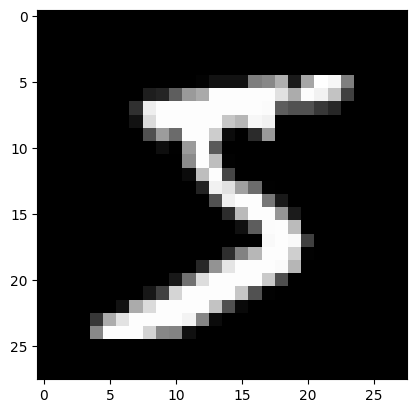

In [446]:
def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()

show_img(X[0])

In [447]:
class CNN:
    def __init__(self, num_classes):
        self.conv = ConvolutionLayer(3, 8)
        self.pool = MaxPool2d(2)
        # self.linear = LinearLayer(13 * 13 * 8, num_classes)
        self.linear = LinearLayer(14 * 14 * 8, num_classes)
        
    
    def forward(self, A):
        output = self.conv.forward(A)
        # print("After Convolution Layer:")
        # print(output.shape)
        # sep()

        output = self.pool.forward(output)
        # print("After Max Pooling Layer:")
        # print(output.shape)
        # sep()
        
        output = self.linear.forward(output)
        # print("After Linear Layer:")
        # print(output.shape)
        
        return output
    
    def backprop(self, y, y_hat, learn_rate):
        grad = np.zeros(y.shape)
        grad[np.argmax(y)] = -1 / y_hat[np.argmax(y)]

        grad = self.linear.backprop(grad, learn_rate)
        grad = self.pool.backprop(grad)
        grad = self.conv.backprop(grad, learn_rate)

        return grad


### How is it 13x13x8?

Input was an image of size 28x28
Now, we have a kernel size of 3 x 3, so we will end up with a 28 - 3 + 1 = 26 x 26 image.
Since we have 8 filters, we will end up with 26 x 26 x 8 image after the first convolutional layer.

Now, we have a max pooling layer with a pool size of 2 x 2, so each block of 2 x 2 pixels will be reduced to 1 pixel. So, we will end up with a 13 x 13 x 8 image after the first max pooling layer.

In [464]:
cnn = CNN(10)

(10,)
9


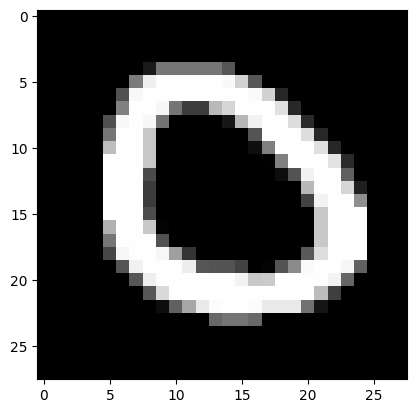

In [466]:
random_index = np.random.randint(0, X.shape[0])
inp = pad(X[random_index], 1)
inp = normalize(inp)

output = cnn.forward(inp)
print(output.shape)
print(np.argmax(output))
show_img(X[random_index])

In [467]:
def cross_entropy_loss(y, y_hat):
    return -np.sum(y * np.log(y_hat))

In [468]:
def testing_accuracy():
    correct = 0
    for i in range(X_test.shape[0]):
        inp = pad(X_test[i], 1)
        inp = normalize(inp)
        output = cnn.forward(inp)
        if np.argmax(output) == y_test[i]:
            correct += 1
    return correct / X.shape[0]

In [470]:
testing_accuracy()

0.052

In [457]:
def train(im, label, lr=.005):
    # Forward
    out = cnn.forward(im)
    loss = cross_entropy_loss(label, out)
    cnn.backprop(label, out, lr)

    return loss

In [460]:
for epoch in range(100):
    epoch_loss = 0
    for i in range(X.shape[0]):
        inp = pad(X[i], 1)
        inp = normalize(inp)
        loss = train(inp, y_one_hot[i])
        epoch_loss += loss
    
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / X.shape[0]}, Accuracy: {testing_accuracy()}")

Epoch 1, Loss: 0.10866504561883059, Accuracy: 0.417
Epoch 2, Loss: 0.0834994601655843, Accuracy: 0.441
Epoch 3, Loss: 0.053430469483054376, Accuracy: 0.433
Epoch 4, Loss: 0.03690342002231515, Accuracy: 0.44
Epoch 5, Loss: 0.02391962134572053, Accuracy: 0.44
Epoch 6, Loss: 0.01708781693263299, Accuracy: 0.444
Epoch 7, Loss: 0.013039423869068038, Accuracy: 0.445
Epoch 8, Loss: 0.010578803588159663, Accuracy: 0.445
Epoch 9, Loss: 0.00886390083673022, Accuracy: 0.445
Epoch 10, Loss: 0.007600068493470269, Accuracy: 0.445
Epoch 11, Loss: 0.006623727636900472, Accuracy: 0.446
Epoch 12, Loss: 0.005847490957518882, Accuracy: 0.445
Epoch 13, Loss: 0.005217739001754394, Accuracy: 0.445
Epoch 14, Loss: 0.004699117519604556, Accuracy: 0.445
Epoch 15, Loss: 0.0042668378742401316, Accuracy: 0.445
Epoch 16, Loss: 0.003902076088800789, Accuracy: 0.445
Epoch 17, Loss: 0.0035909536020176094, Accuracy: 0.444
Epoch 18, Loss: 0.0033231403965474867, Accuracy: 0.444
Epoch 19, Loss: 0.0030907023011545543, Accu

KeyboardInterrupt: 